# ARIMA Forecast

Building on the triple exponential smoothing model to try and construct a reliable forecast of the fire calls data, an ARIMA model is to be applied across the training data and tested for MAE and RMSE minimsation, as before.

In [36]:
# Import libraries

import time
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d # Linear interpolation method
from scipy.stats import linregress, norm # For linear regression analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # For automatic ARIMA model selection
from statsmodels.tsa.seasonal import seasonal_decompose # For seasonal decomposition
from statsmodels.tsa.stattools import adfuller
from joblib import delayed, Parallel # For parallel processing
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plotting autocorrelation and partial autocorrelation
import seaborn as sns

# Format plotting
sns.set_theme(context="notebook", style="darkgrid", palette = "flare")
palette = sns.color_palette("flare", as_cmap=False)
palette_cmap = sns.color_palette("flare", as_cmap=True)

            FireCount
DateTime             
2019-01-06       1486
2019-01-13       1680
2019-01-20       1789
2019-01-27       1867
2019-02-03       1782


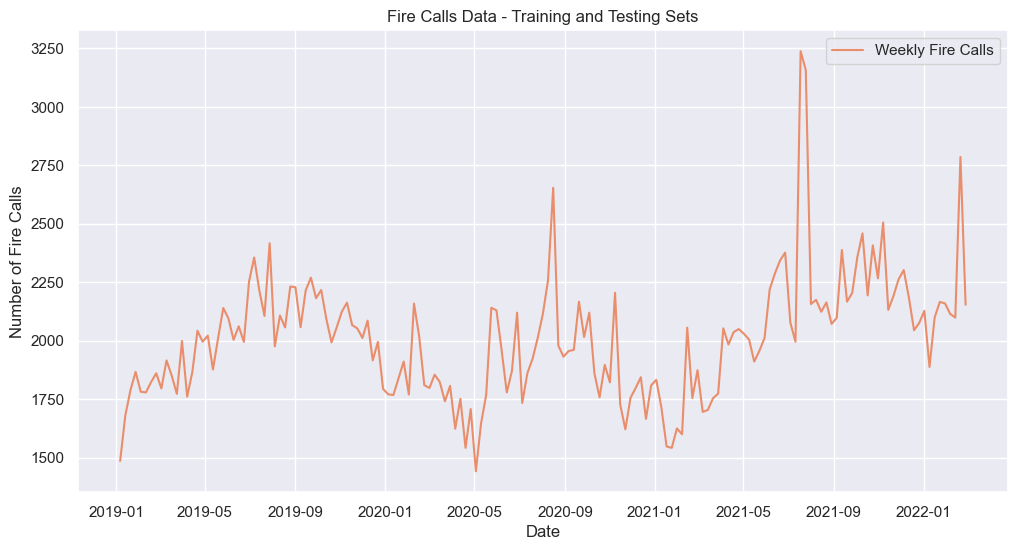

In [37]:
# Import and restructure the data once again, dividing into training and testing sets

data_path = os.path.join(os.getcwd(), 'Data Sets')
plot_path = os.path.join(os.getcwd(), 'Plots', 'Predictive_analysis')

fire_data = pd.read_csv(os.path.join(data_path, 'Fire_data.csv'))
# Covert DateOfCall and TimeOfCall data type to datetime in a single column
fire_data['DateTime'] = pd.to_datetime(fire_data['DateOfCall'] + ' ' + fire_data['TimeOfCall'])
fire_data.set_index('DateTime', inplace=True)
# Drop the original DateOfCall and TimeOfCall columns
fire_data.drop(columns=['DateOfCall', 'TimeOfCall', 'CalYear', 'HourOfCall'], inplace=True)

# Resample the data to weekly frequency, summing the number of calls per week
fire_weekly = fire_data.resample('W').size().reset_index(name='FireCount')
fire_weekly['DateTime'] = pd.to_datetime(fire_weekly['DateTime'])
fire_weekly.set_index('DateTime', inplace=True)
print(fire_weekly.head())

# Omit final value
fire_weekly = fire_weekly[:-1]
# Ensure the frequency is explicitly set to weekly
fire_weekly = fire_weekly.asfreq('W-SUN')

# Split the data into training and testing sets
train_size = int(len(fire_weekly) * 0.8)
train_data = fire_weekly[:train_size]
test_size = len(fire_weekly) - train_size
test_data = fire_weekly[train_size:]

# Plot the weekly data
plt.figure(figsize=(12, 6))
plt.plot(fire_weekly.index, fire_weekly['FireCount'], label='Weekly Fire Calls', color=palette[0])
plt.title('Fire Calls Data - Training and Testing Sets')
plt.xlabel('Date')
plt.ylabel('Number of Fire Calls')
plt.legend()
plt.show()


In [38]:
# Check stationarity of the data using the Augmented Dickey-Fuller test

result = adfuller(fire_weekly['FireCount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.0520161285802345
p-value: 0.26424141649977445
Critical Values:
   1%: -3.4724305215713156
   5%: -2.8800127935315465
   10%: -2.576619230892485


Because the ADF statistic is greater than the values at 1%, 5% and 10% significance levels, the data must be considered non-stationary

ADF Statistic after differencing: -8.287482981039128
p-value after differencing: 4.3510906129898233e-13
Critical Values after differencing:
   1%: -3.4724305215713156
   5%: -2.8800127935315465
   10%: -2.576619230892485
The data is stationary at the 1% significance level after differencing.


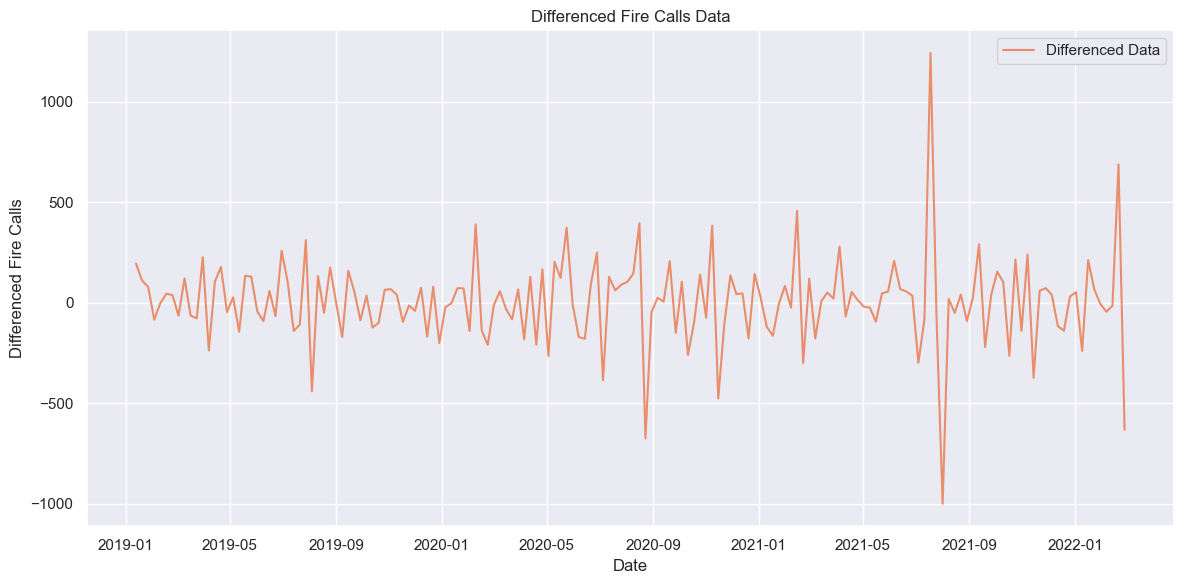

In [39]:
# Apply differencing to make the data stationary if necessary
fire_weekly_diff = fire_weekly['FireCount'].diff().dropna()

# Recheck stationarity after differencing
result_diff = adfuller(fire_weekly_diff)
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])
print('Critical Values after differencing:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

# Print if the data is stationary at 1%
if result_diff[1] < 0.01:
    print("The data is stationary at the 1% significance level after differencing.")

# Show the differenced data
plt.figure(figsize=(12, 6))
plt.plot(fire_weekly_diff.index, fire_weekly_diff, label='Differenced Data', color=palette[0])
plt.title('Differenced Fire Calls Data')
plt.xlabel('Date')
plt.ylabel('Differenced Fire Calls')
plt.legend()
plt.tight_layout()
plt.show()

Differencing the data creates additional noise but ensures stationarity. We can use auto-correlation and partial auto-correlation plots to determine the AR/MA parameters. The ACF plot provides information on the regression, while the PACF plot provides more information on the MA parameters.

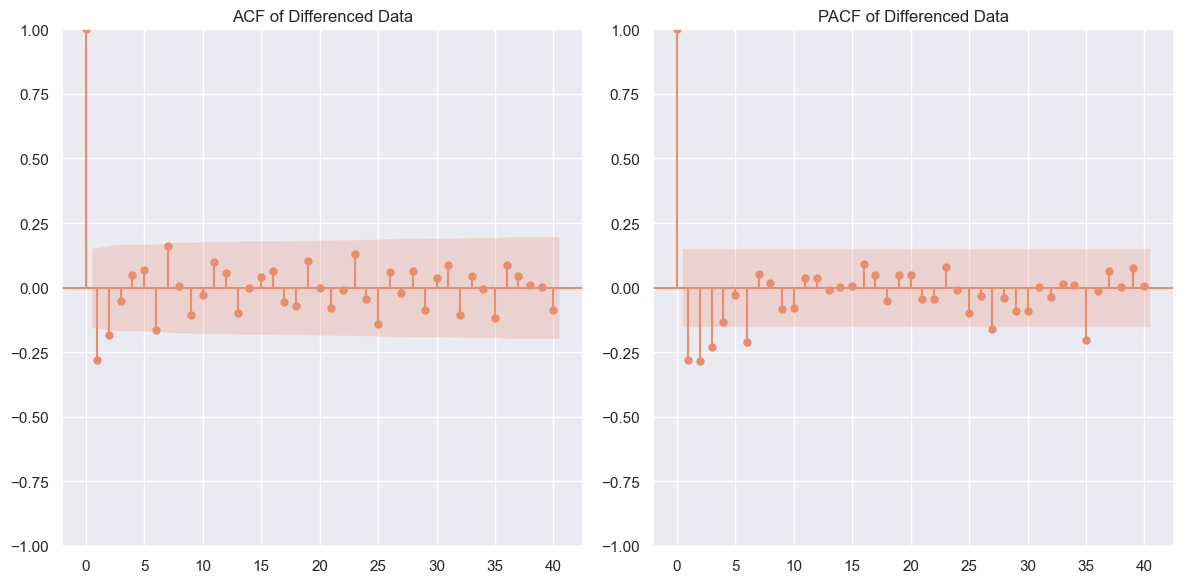

In [40]:
# Plot the ACF and PACF of the differenced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(fire_weekly_diff, lags=40, ax=ax1)
plot_pacf(fire_weekly_diff, lags=40, ax=ax2)
ax1.set_title('ACF of Differenced Data')
ax2.set_title('PACF of Differenced Data')
plt.tight_layout()
plt.show()

The plots above show significance at the 3rd lag, and so we should start with a simple AR(3) model

c:\Users\conal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Mean of Residuals: 1.63


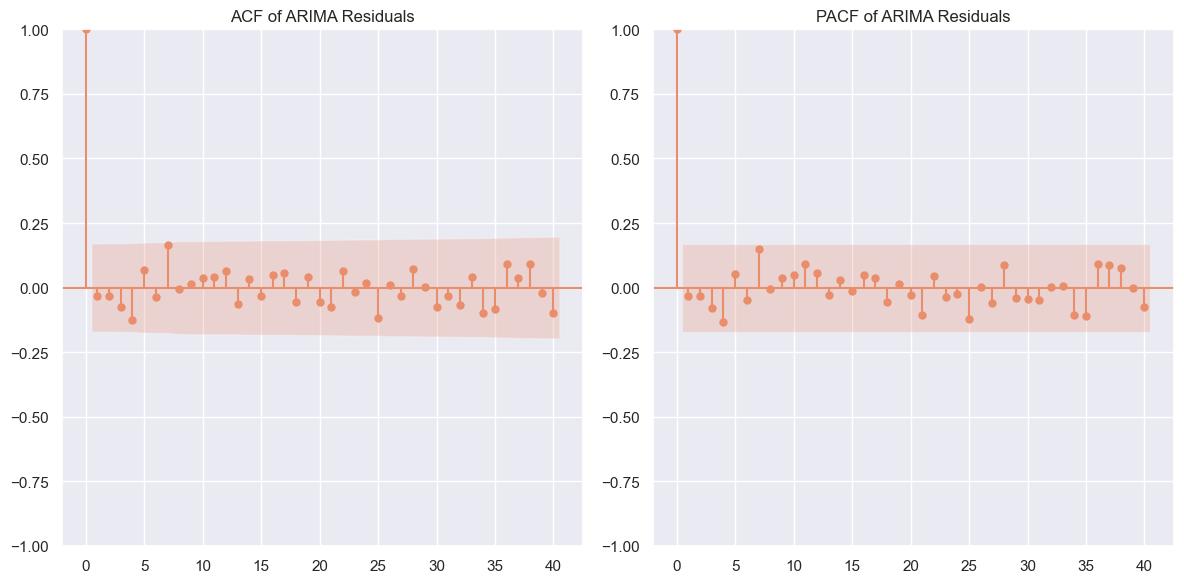

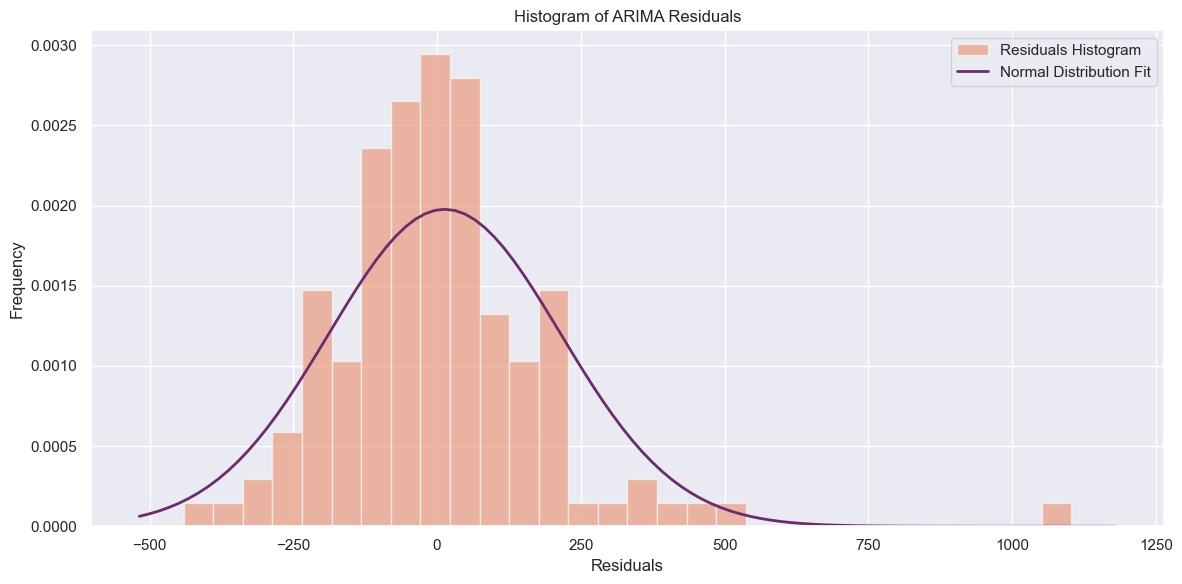

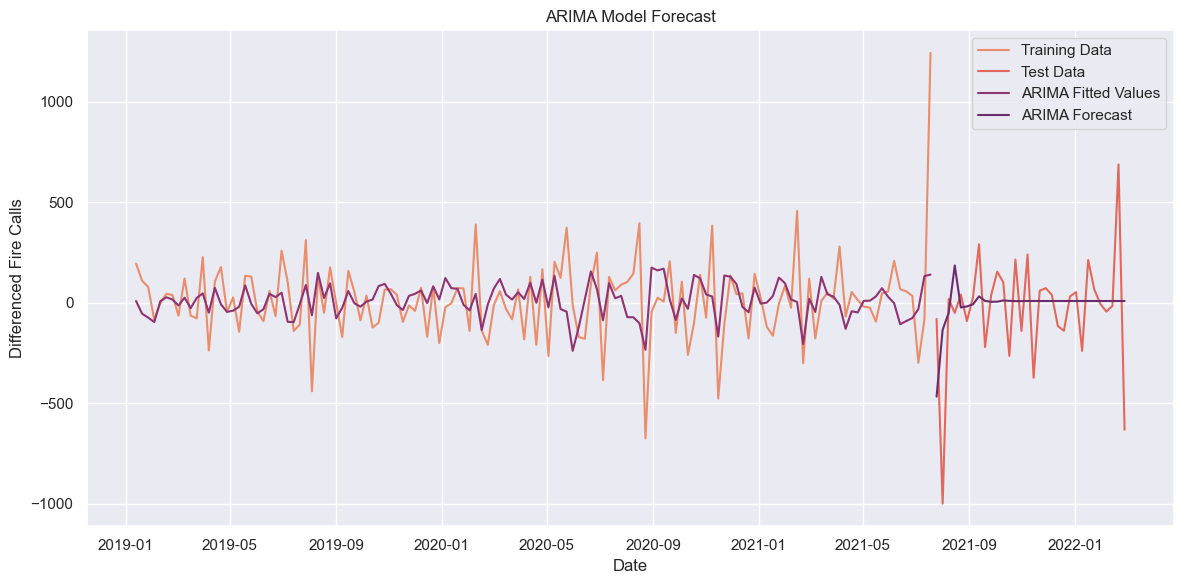

In [41]:
# Plot an ARIMA (3, 0, 0) model on the differenced data divided into training and test sets

# Split data
train_diff = fire_weekly_diff.iloc[:train_size]
test_diff = fire_weekly_diff.iloc[train_size:train_size + test_size]

# Add frequency information to the index
train_diff.index.freq = 'W-SUN'
test_diff.index.freq = 'W-SUN'

# Model
model_arima = ARIMA(train_diff, order=(3, 0, 0)).fit()
forecast_arima = model_arima.predict(start=test_diff.index[0], end=test_diff.index[-1], typ='levels')

# Get forecast info
forecast_info = model_arima.get_forecast(steps=len(test_diff))
forecast_conf_int = forecast_info.conf_int()
forecast_mean = forecast_info.predicted_mean

# Get residuals and plot histogram
residuals = model_arima.resid
mean_of_resids = np.mean(residuals)

print(f"Mean of Residuals: {mean_of_resids:.2f}")

# Plot auto-correlation of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(residuals, lags=40, ax=ax1)
ax1.set_title('ACF of ARIMA Residuals')
plot_pacf(residuals, lags=40, ax=ax2)
ax2.set_title('PACF of ARIMA Residuals')
plt.tight_layout()
plt.show()

# Plot the histogram of the residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color=palette[0], label='Residuals Histogram')
mean_resid, std_resid = norm.fit(train_diff)
xmin, xmax = plt.xlim() # Constrain the x-axis limits
curve_length = np.linspace(xmin, xmax, 100) # Create 100 bars for clearer distribution
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, lw=2, label='Normal Distribution Fit', color = palette[-1])
plt.title('Histogram of ARIMA Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the ARIMA model against actual data
plt.figure(figsize=(12, 6))
plt.plot(train_diff.index, train_diff, label='Training Data', color=palette[0])
plt.plot(test_diff.index, test_diff, label='Test Data', color=palette[1])
plt.plot(model_arima.fittedvalues.index, model_arima.fittedvalues, label='ARIMA Fitted Values', color=palette[-2])
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color=palette[-1])

plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Differenced Fire Calls')
plt.legend()
plt.tight_layout()
plt.show()


The normal distribution histogram plot shows that some residuals are much greater than they should be, and so the normal distribution is not steep enough. There are significant residuals at the 4th, 6th and 7th lags.

c:\Users\conal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


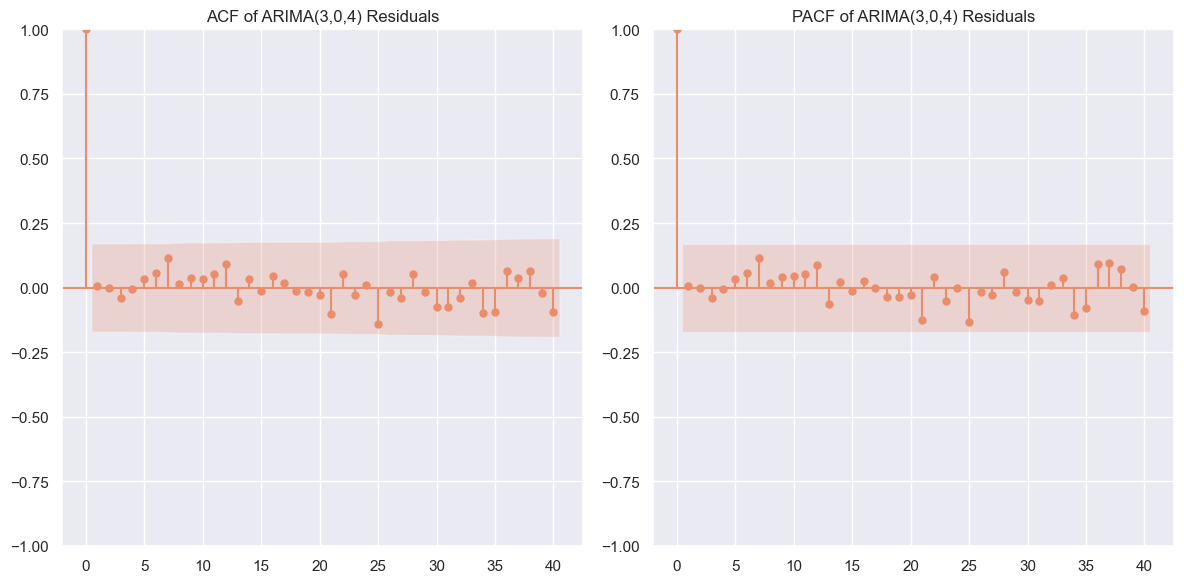

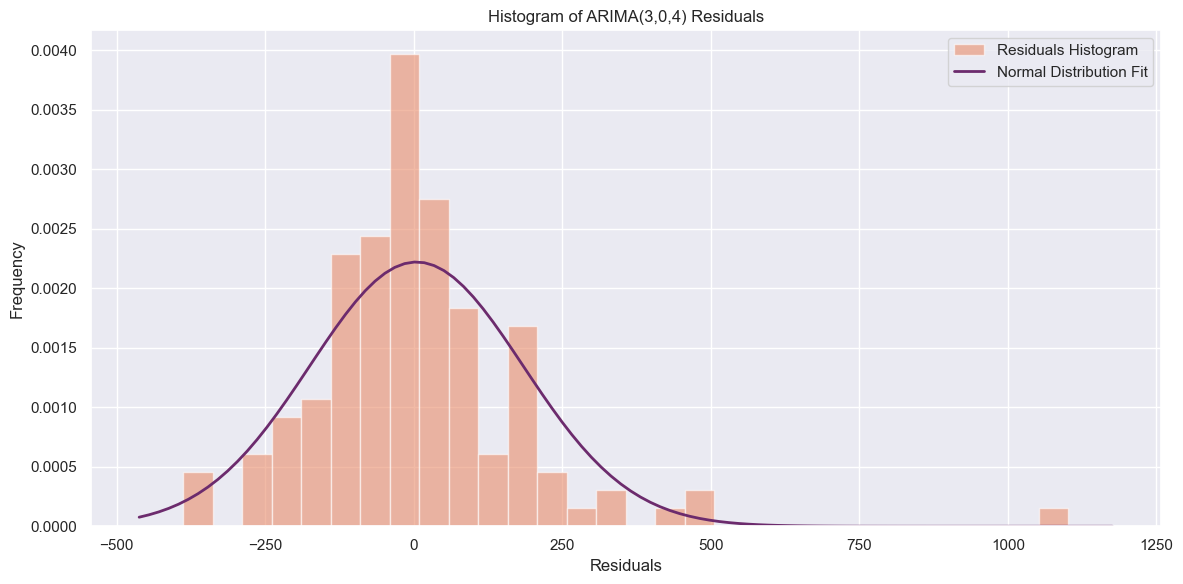

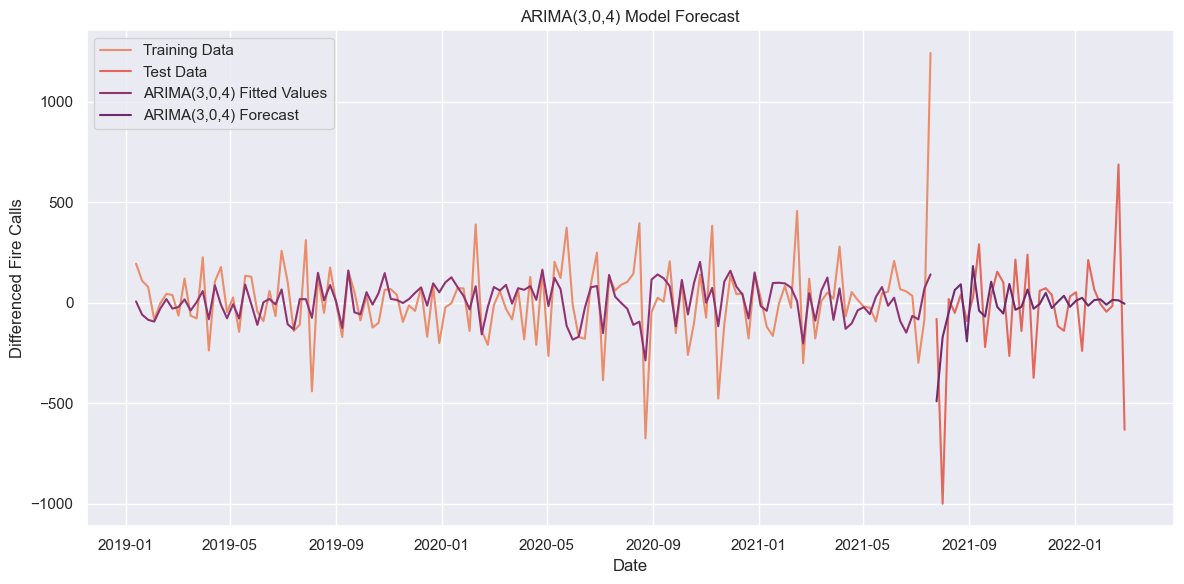

In [42]:
# Plot an ARIMA model with (3, 0, 4)

model_arima_34 = ARIMA(train_diff, order=(3, 0, 4)).fit()
forecast_arima_34 = model_arima_34.predict(start=test_diff.index[0], end=test_diff.index[-1], typ='levels')

# Plot ACF and PACF of residuals
residuals_34 = model_arima_34.resid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(residuals_34, lags=40, ax=ax1)
ax1.set_title('ACF of ARIMA(3,0,4) Residuals')
plot_pacf(residuals_34, lags=40, ax=ax2)
ax2.set_title('PACF of ARIMA(3,0,4) Residuals')
plt.tight_layout()
plt.show()

# Plot the histogram of the residuals for ARIMA(3,0,4)
plt.figure(figsize=(12, 6))
plt.hist(residuals_34, bins=30, density=True, alpha=0.6, color=palette[0], label='Residuals Histogram')
mean_resid_34, std_resid_34 = norm.fit(residuals_34)
xmin, xmax = plt.xlim()  # Constrain the x-axis limits
curve_length_34 = np.linspace(xmin, xmax, 100)  # Create 100 bars for clearer distribution
bell_curve_34 = norm.pdf(curve_length_34, mean_resid_34, std_resid_34)
plt.plot(curve_length_34, bell_curve_34, lw=2, label='Normal Distribution Fit', color=palette[-1])
plt.title('Histogram of ARIMA(3,0,4) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the ARIMA(3,0,4) model against actual data
plt.figure(figsize=(12, 6))
plt.plot(train_diff.index, train_diff, label='Training Data', color=palette[0])
plt.plot(test_diff.index, test_diff, label='Test Data', color=palette[1])
plt.plot(model_arima_34.fittedvalues.index, model_arima_34.fittedvalues, label='ARIMA(3,0,4) Fitted Values', color=palette[-2])
plt.plot(forecast_arima_34.index, forecast_arima_34, label='ARIMA(3,0,4) Forecast', color=palette[-1])

plt.title('ARIMA(3,0,4) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Differenced Fire Calls')
plt.legend()
plt.tight_layout()
plt.show()

The integral component of the ARIMA forecast accounts for non-stationarity in model. The ARIMA model will then be applied to the original test and training data with a single integral term.

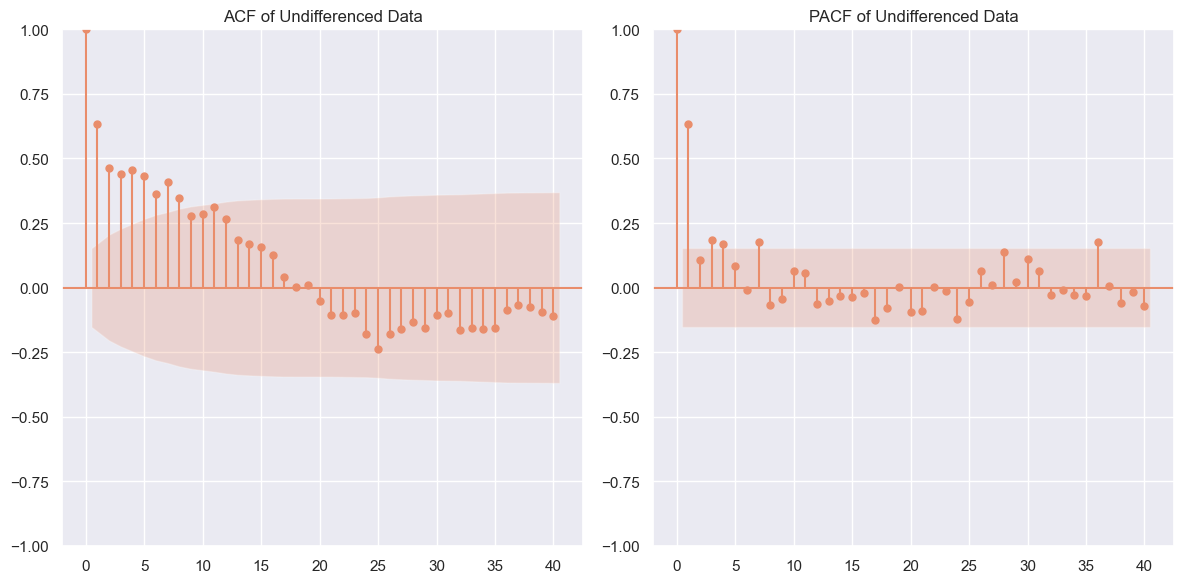

In [43]:
# Plot the ACF and PACF of the undifferenced data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(fire_weekly['FireCount'], lags=40, ax=ax1)
plot_pacf(fire_weekly['FireCount'], lags=40, ax=ax2)
ax1.set_title('ACF of Undifferenced Data')
ax2.set_title('PACF of Undifferenced Data')
plt.tight_layout()
plt.show()

Given the residuals from the ACF/PCAF functions, the highest index lag outside the confidence interval (indicating the MA term) is at 8, and the greatest error lag outside the confidence interval (indicating the AR term) is at 2. This gives ARIMA parameters of (8, 1, 2)

c:\Users\conal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


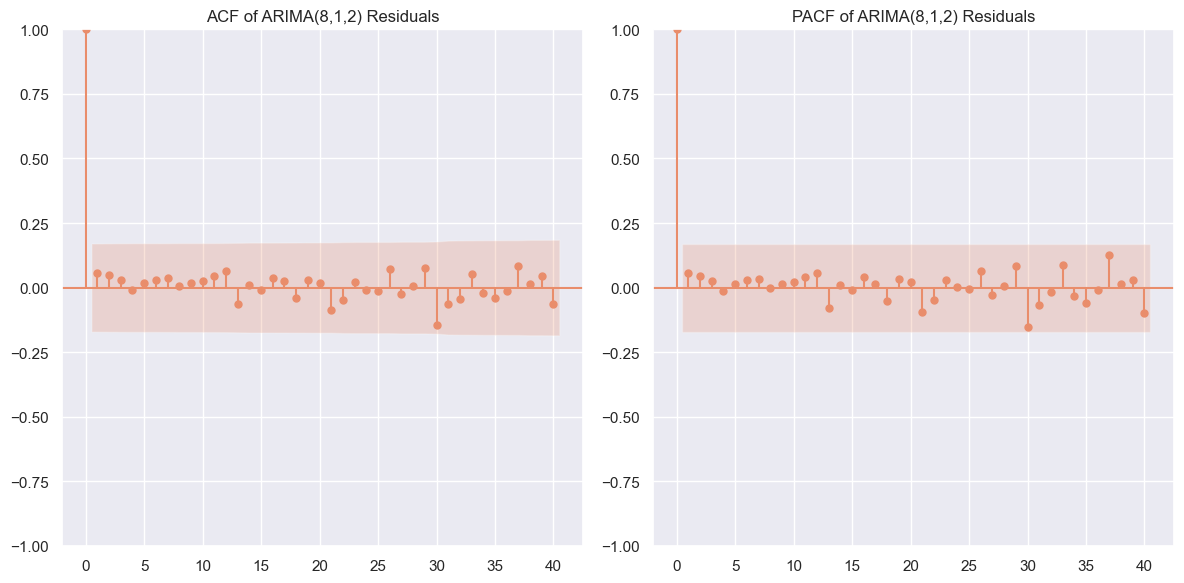

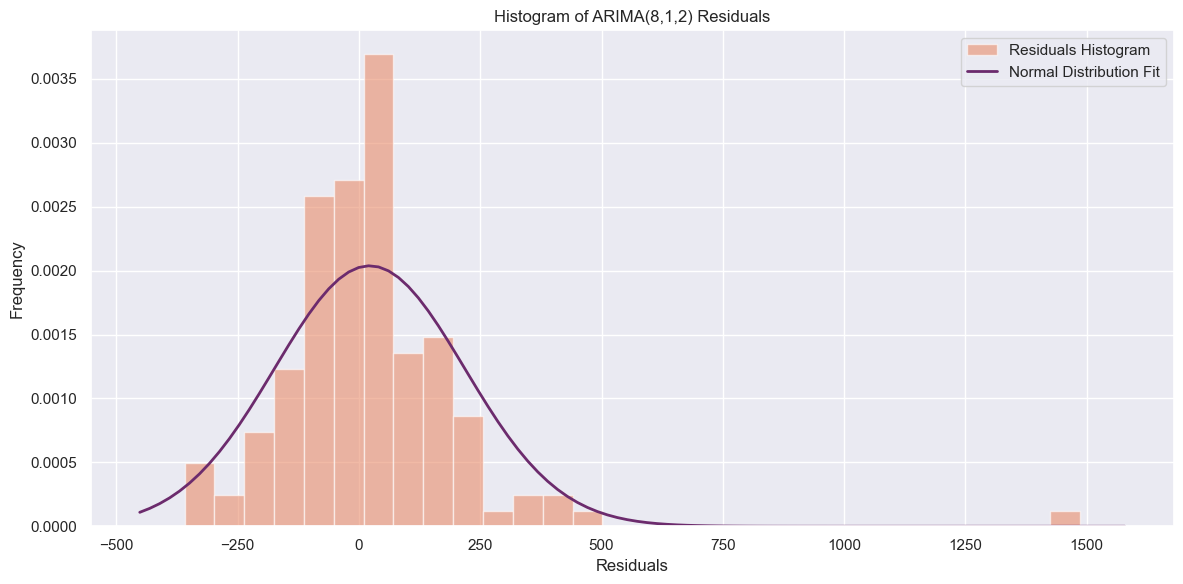

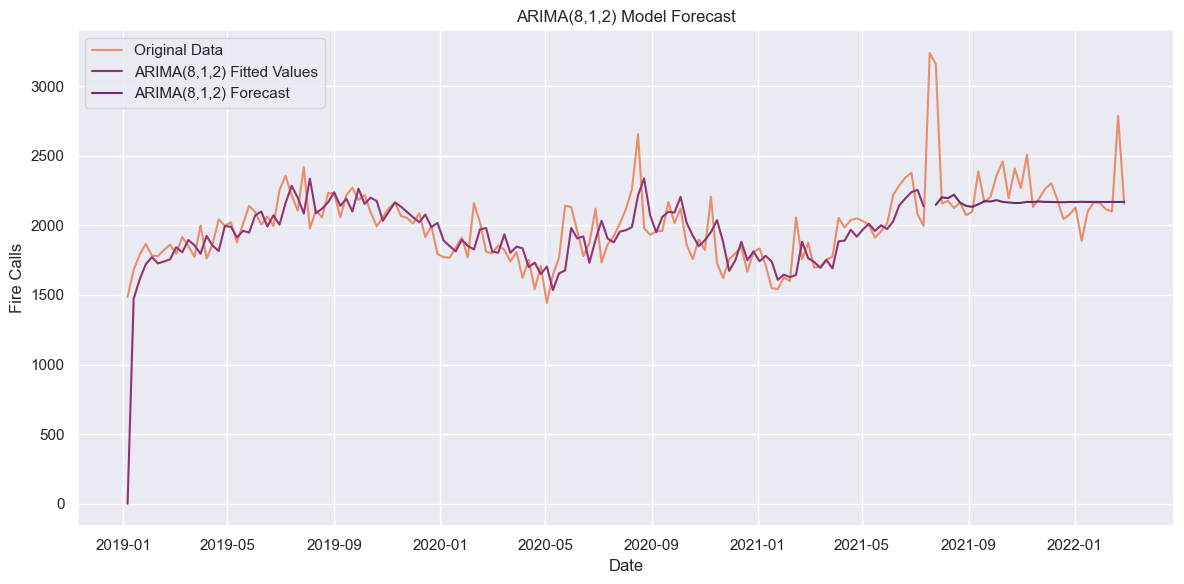

In [ ]:
# Plot the ARIMA model with (8, 1, 2)

model_arima_812 = ARIMA(train_data['FireCount'], order=(8, 1, 2)).fit()
forecast_arima_812 = model_arima_812.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')

# Plot ACF and PACF of residuals for ARIMA(2,1,2)
residuals_812 = model_arima_812.resid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(residuals_812, lags=40, ax=ax1)
ax1.set_title('ACF of ARIMA(8,1,2) Residuals')
plot_pacf(residuals_812, lags=40, ax=ax2)
ax2.set_title('PACF of ARIMA(8,1,2) Residuals')
plt.tight_layout()
plt.show()

# Plot the histogram of the residuals for ARIMA(8,1,2)
plt.figure(figsize=(12, 6))
plt.hist(residuals_812, bins=30, density=True, alpha=0.6, color=palette[0], label='Residuals Histogram')
mean_resid_812, std_resid_812 = norm.fit(residuals_812)
xmin, xmax = plt.xlim()  # Constrain the x-axis limits
curve_length_812 = np.linspace(xmin, xmax, 100)  # Create
# 100 bars for clearer distribution
bell_curve_812 = norm.pdf(curve_length_812, mean_resid_812, std_resid_812)
plt.plot(curve_length_812, bell_curve_812, lw=2, label='Normal Distribution Fit', color=palette[-1])
plt.title('Histogram of ARIMA(8,1,2) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the ARIMA(8,1,2) model against actual data
plt.figure(figsize=(12, 6))
plt.plot(fire_weekly.index, fire_weekly['FireCount'], label='Original Data', color=palette[0])
plt.plot(model_arima_812.fittedvalues.index, model_arima_812.fittedvalues, label='ARIMA(8,1,2) Fitted Values', color=palette[-2])
plt.plot(forecast_arima_812.index, forecast_arima_812, label='ARIMA(8,1,2) Forecast', color=palette[-1])
plt.title('ARIMA(8,1,2) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Fire Calls')
plt.legend()
plt.tight_layout()
plt.show()

Best ARIMA parameters: p=0, d=1, q=5
Best MAE: 167.95, Best RMSE: 312.96


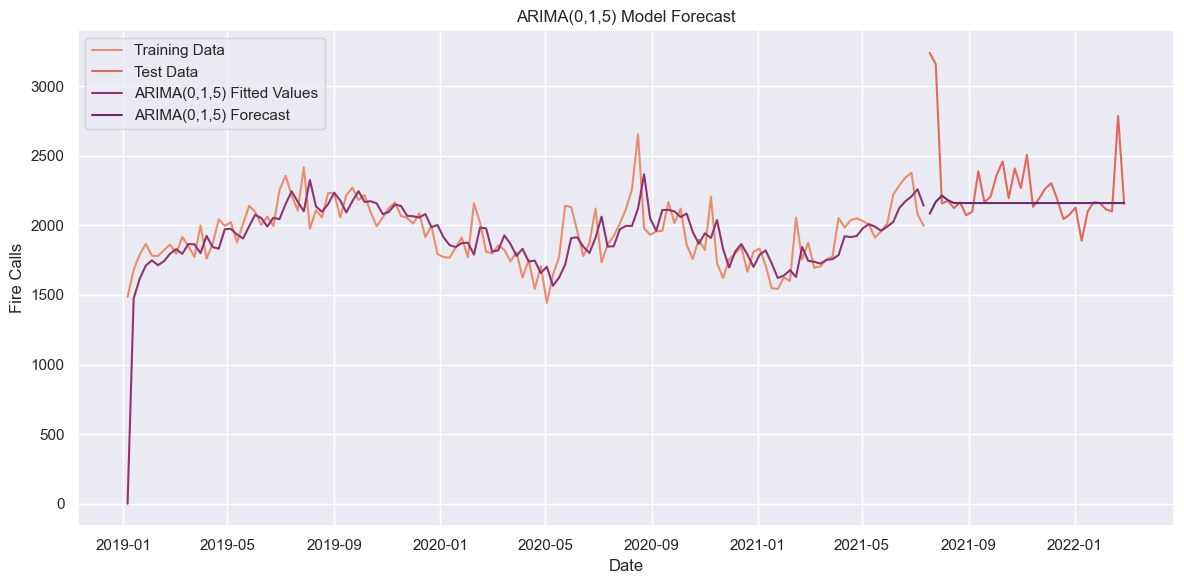

In [54]:
# Create a hyperparameter search for p, d, q values that yield the smallest MAE and RMSE values when tested against the test set

def evaluate_arima_model(train, test, p, d, q):
    """
    Evaluate an ARIMA model on the training and testing data.
    
    Parameters:
    train (pd.Series): Training data.
    test (pd.Series): Testing data.
    p (int): AR order.
    d (int): Differencing order.
    q (int): MA order.
    
    Returns:
    tuple: MAE and RMSE of the model.
    """
    model = ARIMA(train, order=(p, d, q)).fit()
    forecast = model.predict(start=test.index[0], end=test.index[-1], typ='levels')
    
    mae = np.mean(np.abs(forecast - test))
    rmse = np.sqrt(np.mean((forecast - test) ** 2))
    
    return mae, rmse

def grid_search_arima(train, test, p_values, d_values, q_values):
    """
    Perform a grid search for ARIMA hyperparameters.
    
    Parameters:
    train (pd.Series): Training data.
    test (pd.Series): Testing data.
    p_values (list): List of AR orders to test.
    d_values (list): List of differencing orders to test.
    q_values (list): List of MA orders to test.
    
    Returns:
    tuple: Best parameters and their corresponding MAE and RMSE.
    """
    best_mae, best_rmse = float('inf'), float('inf')
    best_params = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                mae, rmse = evaluate_arima_model(train, test, p, d, q)
                if mae < best_mae or (mae == best_mae and rmse < best_rmse):
                    best_mae, best_rmse = mae, rmse
                    best_params = (p, d, q)
    
    return best_params, best_mae, best_rmse

# Define the parameter grid
p_values = range(0, 9)  # AR order
d_values = range(0, 3)  # Differencing order
q_values = range(0, 9)  # MA order

# Perform grid search
best_params, best_mae, best_rmse = grid_search_arima(train_data['FireCount'], test_data['FireCount'], p_values, d_values, q_values)

print(f"Best ARIMA parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}")
print(f"Best MAE: {best_mae:.2f}, Best RMSE: {best_rmse:.2f}")

# Plot the the best ARIMA model against the test data
best_model = ARIMA(train_data['FireCount'], order=best_params).fit()
forecast_best = best_model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['FireCount'], label='Training Data', color=palette[0])
plt.plot(test_data.index, test_data['FireCount'], label='Test Data', color=palette[1])
plt.plot(best_model.fittedvalues.index, best_model.fittedvalues, label=f'ARIMA({best_params[0]},{best_params[1]},{best_params[2]}) Fitted Values', color=palette[-2])
plt.plot(forecast_best.index, forecast_best, label=f'ARIMA({best_params[0]},{best_params[1]},{best_params[2]}) Forecast', color=palette[-1])
plt.title(f'ARIMA({best_params[0]},{best_params[1]},{best_params[2]}) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Fire Calls')
plt.legend()
plt.tight_layout()
plt.show()
